# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=250  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=512, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=64, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=64, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

In [10]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


     


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    # cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    # cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), (1024,1)]
    #cfg = [48, (96,2), 96, (192,2), 192, (384,2), 384, 384, 384, 384, 384, (768,2), (1024,1)]
    cfg = [64, (128,2), 128, 256, 256, (512,2), 512, 512, 512, 512, 512,1024,1024]
    #cfg = [48, (96,2), 96, 192, 192, (384,2), 384, 384, 384, 384, 384,768,768]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        #print("X",out.shape)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [11]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150,200,230,250], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [12]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 10*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1=open("Cifar10_INFO.txt","a+")
#             f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [13]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         valid_loss, correct, len(valid_idx),
#         100. * correct / len(valid_idx)))
#     f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [14]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct.cpu().numpy() / len(test_loader.dataset)))
#     f1.close()

In [15]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [16]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
#from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=10 and (epoch-10)%2==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.312765, Accuracy: 9.77
Train Epoch: 0 [5120/50000 (11%)]	Loss: 1.991242, Accuracy: 21.68
Train Epoch: 0 [10240/50000 (23%)]	Loss: 1.912407, Accuracy: 22.07
Train Epoch: 0 [15360/50000 (34%)]	Loss: 1.770051, Accuracy: 30.86
Train Epoch: 0 [20480/50000 (45%)]	Loss: 1.648032, Accuracy: 39.84
Train Epoch: 0 [25600/50000 (57%)]	Loss: 1.626082, Accuracy: 39.84
Train Epoch: 0 [30720/50000 (68%)]	Loss: 1.509295, Accuracy: 44.92
Train Epoch: 0 [35840/50000 (80%)]	Loss: 1.512161, Accuracy: 44.73
Train Epoch: 0 [40960/50000 (91%)]	Loss: 1.425080, Accuracy: 46.48

Validation set: Average loss: 1.4715, Accuracy: 2317/5000 (46.00%)

the time of this epoch:[33.593266248703 s]
Train Epoch: 1 [0/50000 (0%)]	Loss: 1.376790, Accuracy: 52.15
Train Epoch: 1 [5120/50000 (11%)]	Loss: 1.338377, Accuracy: 52.54
Train Epoch: 1 [10240/50000 (23%)]	Loss: 1.314832, Accuracy: 52.73
Train Epoch: 1 [15360/50000 (34%)]	Loss: 1.263599, Accuracy: 55.86
Train Epoch: 1 [20480/50000 (4

Train Epoch: 11 [25600/50000 (57%)]	Loss: 0.411617, Accuracy: 84.96
Train Epoch: 11 [30720/50000 (68%)]	Loss: 0.379037, Accuracy: 85.74
Train Epoch: 11 [35840/50000 (80%)]	Loss: 0.388183, Accuracy: 86.52
Train Epoch: 11 [40960/50000 (91%)]	Loss: 0.410870, Accuracy: 84.96

Validation set: Average loss: 0.5167, Accuracy: 4123/5000 (82.00%)

the time of this epoch:[36.02229070663452 s]
Train Epoch: 12 [0/50000 (0%)]	Loss: 0.416173, Accuracy: 86.33
Train Epoch: 12 [5120/50000 (11%)]	Loss: 0.372032, Accuracy: 86.72
Train Epoch: 12 [10240/50000 (23%)]	Loss: 0.439787, Accuracy: 84.57
Train Epoch: 12 [15360/50000 (34%)]	Loss: 0.404442, Accuracy: 85.35
Train Epoch: 12 [20480/50000 (45%)]	Loss: 0.348946, Accuracy: 89.06
Train Epoch: 12 [25600/50000 (57%)]	Loss: 0.376653, Accuracy: 86.91
Train Epoch: 12 [30720/50000 (68%)]	Loss: 0.369178, Accuracy: 87.50
Train Epoch: 12 [35840/50000 (80%)]	Loss: 0.337704, Accuracy: 87.70
Train Epoch: 12 [40960/50000 (91%)]	Loss: 0.363622, Accuracy: 88.87

Validat

Train Epoch: 22 [25600/50000 (57%)]	Loss: 0.310091, Accuracy: 88.48
Train Epoch: 22 [30720/50000 (68%)]	Loss: 0.264506, Accuracy: 91.21
Train Epoch: 22 [35840/50000 (80%)]	Loss: 0.281808, Accuracy: 89.84
Train Epoch: 22 [40960/50000 (91%)]	Loss: 0.370994, Accuracy: 85.94

Validation set: Average loss: 0.5554, Accuracy: 4089/5000 (81.00%)

the time of this epoch:[32.95141959190369 s]

Test set: Average loss: 0.5883, Accuracy: 8090/10000 (80.90%)

Train Epoch: 23 [0/50000 (0%)]	Loss: 0.223311, Accuracy: 93.36
Train Epoch: 23 [5120/50000 (11%)]	Loss: 0.232177, Accuracy: 92.19
Train Epoch: 23 [10240/50000 (23%)]	Loss: 0.290994, Accuracy: 91.02
Train Epoch: 23 [15360/50000 (34%)]	Loss: 0.275071, Accuracy: 90.04
Train Epoch: 23 [20480/50000 (45%)]	Loss: 0.261936, Accuracy: 89.26
Train Epoch: 23 [25600/50000 (57%)]	Loss: 0.273328, Accuracy: 90.62
Train Epoch: 23 [30720/50000 (68%)]	Loss: 0.220545, Accuracy: 92.77
Train Epoch: 23 [35840/50000 (80%)]	Loss: 0.233925, Accuracy: 92.19
Train Epoch:

Train Epoch: 33 [20480/50000 (45%)]	Loss: 0.261793, Accuracy: 91.99
Train Epoch: 33 [25600/50000 (57%)]	Loss: 0.214480, Accuracy: 92.58
Train Epoch: 33 [30720/50000 (68%)]	Loss: 0.263509, Accuracy: 90.04
Train Epoch: 33 [35840/50000 (80%)]	Loss: 0.210856, Accuracy: 92.77
Train Epoch: 33 [40960/50000 (91%)]	Loss: 0.268864, Accuracy: 90.82

Validation set: Average loss: 0.4972, Accuracy: 4200/5000 (84.00%)

the time of this epoch:[37.34468960762024 s]
Train Epoch: 34 [0/50000 (0%)]	Loss: 0.215051, Accuracy: 92.58
Train Epoch: 34 [5120/50000 (11%)]	Loss: 0.171380, Accuracy: 93.95
Train Epoch: 34 [10240/50000 (23%)]	Loss: 0.176860, Accuracy: 94.53
Train Epoch: 34 [15360/50000 (34%)]	Loss: 0.203250, Accuracy: 92.19
Train Epoch: 34 [20480/50000 (45%)]	Loss: 0.225929, Accuracy: 91.80
Train Epoch: 34 [25600/50000 (57%)]	Loss: 0.238446, Accuracy: 92.38
Train Epoch: 34 [30720/50000 (68%)]	Loss: 0.255883, Accuracy: 90.43
Train Epoch: 34 [35840/50000 (80%)]	Loss: 0.209407, Accuracy: 93.95
Train Ep

Train Epoch: 44 [20480/50000 (45%)]	Loss: 0.233697, Accuracy: 92.38
Train Epoch: 44 [25600/50000 (57%)]	Loss: 0.214312, Accuracy: 92.97
Train Epoch: 44 [30720/50000 (68%)]	Loss: 0.166839, Accuracy: 93.95
Train Epoch: 44 [35840/50000 (80%)]	Loss: 0.199620, Accuracy: 92.58
Train Epoch: 44 [40960/50000 (91%)]	Loss: 0.271456, Accuracy: 90.43

Validation set: Average loss: 0.4976, Accuracy: 4230/5000 (84.00%)

the time of this epoch:[32.760562896728516 s]

Test set: Average loss: 0.5221, Accuracy: 8394/10000 (83.94%)

Train Epoch: 45 [0/50000 (0%)]	Loss: 0.240636, Accuracy: 91.80
Train Epoch: 45 [5120/50000 (11%)]	Loss: 0.230184, Accuracy: 91.80
Train Epoch: 45 [10240/50000 (23%)]	Loss: 0.167047, Accuracy: 94.73
Train Epoch: 45 [15360/50000 (34%)]	Loss: 0.191614, Accuracy: 93.75
Train Epoch: 45 [20480/50000 (45%)]	Loss: 0.214132, Accuracy: 91.80
Train Epoch: 45 [25600/50000 (57%)]	Loss: 0.241856, Accuracy: 91.41
Train Epoch: 45 [30720/50000 (68%)]	Loss: 0.188779, Accuracy: 93.16
Train Epoch

Train Epoch: 55 [15360/50000 (34%)]	Loss: 0.214509, Accuracy: 91.80
Train Epoch: 55 [20480/50000 (45%)]	Loss: 0.263766, Accuracy: 90.23
Train Epoch: 55 [25600/50000 (57%)]	Loss: 0.213139, Accuracy: 92.97
Train Epoch: 55 [30720/50000 (68%)]	Loss: 0.199125, Accuracy: 93.16
Train Epoch: 55 [35840/50000 (80%)]	Loss: 0.210252, Accuracy: 93.95
Train Epoch: 55 [40960/50000 (91%)]	Loss: 0.185544, Accuracy: 93.95

Validation set: Average loss: 0.4762, Accuracy: 4269/5000 (85.00%)

the time of this epoch:[35.93015646934509 s]
Train Epoch: 56 [0/50000 (0%)]	Loss: 0.232567, Accuracy: 91.80
Train Epoch: 56 [5120/50000 (11%)]	Loss: 0.201531, Accuracy: 93.55
Train Epoch: 56 [10240/50000 (23%)]	Loss: 0.186673, Accuracy: 92.77
Train Epoch: 56 [15360/50000 (34%)]	Loss: 0.180241, Accuracy: 93.55
Train Epoch: 56 [20480/50000 (45%)]	Loss: 0.205761, Accuracy: 92.58
Train Epoch: 56 [25600/50000 (57%)]	Loss: 0.231092, Accuracy: 92.19
Train Epoch: 56 [30720/50000 (68%)]	Loss: 0.167863, Accuracy: 93.95
Train Ep

Train Epoch: 66 [15360/50000 (34%)]	Loss: 0.167361, Accuracy: 93.55
Train Epoch: 66 [20480/50000 (45%)]	Loss: 0.270807, Accuracy: 90.62
Train Epoch: 66 [25600/50000 (57%)]	Loss: 0.188375, Accuracy: 93.16
Train Epoch: 66 [30720/50000 (68%)]	Loss: 0.201417, Accuracy: 93.16
Train Epoch: 66 [35840/50000 (80%)]	Loss: 0.200722, Accuracy: 94.34
Train Epoch: 66 [40960/50000 (91%)]	Loss: 0.223433, Accuracy: 92.77

Validation set: Average loss: 0.5190, Accuracy: 4214/5000 (84.00%)

the time of this epoch:[34.62159872055054 s]

Test set: Average loss: 0.5746, Accuracy: 8317/10000 (83.17%)

Train Epoch: 67 [0/50000 (0%)]	Loss: 0.157352, Accuracy: 95.12
Train Epoch: 67 [5120/50000 (11%)]	Loss: 0.136687, Accuracy: 95.51
Train Epoch: 67 [10240/50000 (23%)]	Loss: 0.151205, Accuracy: 95.31
Train Epoch: 67 [15360/50000 (34%)]	Loss: 0.159781, Accuracy: 95.12
Train Epoch: 67 [20480/50000 (45%)]	Loss: 0.171217, Accuracy: 93.75
Train Epoch: 67 [25600/50000 (57%)]	Loss: 0.156841, Accuracy: 94.73
Train Epoch:

Train Epoch: 77 [10240/50000 (23%)]	Loss: 0.167914, Accuracy: 94.34
Train Epoch: 77 [15360/50000 (34%)]	Loss: 0.149273, Accuracy: 94.53
Train Epoch: 77 [20480/50000 (45%)]	Loss: 0.157336, Accuracy: 94.92
Train Epoch: 77 [25600/50000 (57%)]	Loss: 0.158576, Accuracy: 94.34
Train Epoch: 77 [30720/50000 (68%)]	Loss: 0.179997, Accuracy: 93.16
Train Epoch: 77 [35840/50000 (80%)]	Loss: 0.173222, Accuracy: 93.75
Train Epoch: 77 [40960/50000 (91%)]	Loss: 0.211354, Accuracy: 91.99

Validation set: Average loss: 0.5215, Accuracy: 4234/5000 (84.00%)

the time of this epoch:[36.767317056655884 s]
Train Epoch: 78 [0/50000 (0%)]	Loss: 0.176442, Accuracy: 93.95
Train Epoch: 78 [5120/50000 (11%)]	Loss: 0.157009, Accuracy: 94.92
Train Epoch: 78 [10240/50000 (23%)]	Loss: 0.141562, Accuracy: 95.31
Train Epoch: 78 [15360/50000 (34%)]	Loss: 0.160941, Accuracy: 94.14
Train Epoch: 78 [20480/50000 (45%)]	Loss: 0.232934, Accuracy: 92.19
Train Epoch: 78 [25600/50000 (57%)]	Loss: 0.172949, Accuracy: 93.95
Train E

Train Epoch: 88 [10240/50000 (23%)]	Loss: 0.211100, Accuracy: 93.36
Train Epoch: 88 [15360/50000 (34%)]	Loss: 0.154886, Accuracy: 93.16
Train Epoch: 88 [20480/50000 (45%)]	Loss: 0.232592, Accuracy: 92.38
Train Epoch: 88 [25600/50000 (57%)]	Loss: 0.156604, Accuracy: 93.95
Train Epoch: 88 [30720/50000 (68%)]	Loss: 0.213383, Accuracy: 92.58
Train Epoch: 88 [35840/50000 (80%)]	Loss: 0.216660, Accuracy: 91.99
Train Epoch: 88 [40960/50000 (91%)]	Loss: 0.195131, Accuracy: 93.16

Validation set: Average loss: 0.4513, Accuracy: 4298/5000 (85.00%)

the time of this epoch:[32.80286383628845 s]

Test set: Average loss: 0.4886, Accuracy: 8560/10000 (85.60%)

Train Epoch: 89 [0/50000 (0%)]	Loss: 0.178737, Accuracy: 93.75
Train Epoch: 89 [5120/50000 (11%)]	Loss: 0.164801, Accuracy: 94.53
Train Epoch: 89 [10240/50000 (23%)]	Loss: 0.174322, Accuracy: 93.55
Train Epoch: 89 [15360/50000 (34%)]	Loss: 0.167533, Accuracy: 95.51
Train Epoch: 89 [20480/50000 (45%)]	Loss: 0.152977, Accuracy: 94.53
Train Epoch:

Train Epoch: 99 [5120/50000 (11%)]	Loss: 0.187038, Accuracy: 93.75
Train Epoch: 99 [10240/50000 (23%)]	Loss: 0.159430, Accuracy: 94.34
Train Epoch: 99 [15360/50000 (34%)]	Loss: 0.173564, Accuracy: 95.51
Train Epoch: 99 [20480/50000 (45%)]	Loss: 0.242066, Accuracy: 91.41
Train Epoch: 99 [25600/50000 (57%)]	Loss: 0.161348, Accuracy: 94.53
Train Epoch: 99 [30720/50000 (68%)]	Loss: 0.189076, Accuracy: 92.97
Train Epoch: 99 [35840/50000 (80%)]	Loss: 0.241550, Accuracy: 91.60
Train Epoch: 99 [40960/50000 (91%)]	Loss: 0.233156, Accuracy: 91.21

Validation set: Average loss: 0.5052, Accuracy: 4223/5000 (84.00%)

the time of this epoch:[36.178194522857666 s]
Train Epoch: 100 [0/50000 (0%)]	Loss: 0.162878, Accuracy: 94.73
Train Epoch: 100 [5120/50000 (11%)]	Loss: 0.152072, Accuracy: 94.92
Train Epoch: 100 [10240/50000 (23%)]	Loss: 0.128027, Accuracy: 95.31
Train Epoch: 100 [15360/50000 (34%)]	Loss: 0.147953, Accuracy: 94.73
Train Epoch: 100 [20480/50000 (45%)]	Loss: 0.169061, Accuracy: 93.95
Tra

Train Epoch: 110 [0/50000 (0%)]	Loss: 0.144066, Accuracy: 95.70
Train Epoch: 110 [5120/50000 (11%)]	Loss: 0.185539, Accuracy: 93.55
Train Epoch: 110 [10240/50000 (23%)]	Loss: 0.137858, Accuracy: 95.12
Train Epoch: 110 [15360/50000 (34%)]	Loss: 0.216692, Accuracy: 91.99
Train Epoch: 110 [20480/50000 (45%)]	Loss: 0.180791, Accuracy: 93.95
Train Epoch: 110 [25600/50000 (57%)]	Loss: 0.230027, Accuracy: 91.80
Train Epoch: 110 [30720/50000 (68%)]	Loss: 0.197860, Accuracy: 92.77
Train Epoch: 110 [35840/50000 (80%)]	Loss: 0.149554, Accuracy: 95.70
Train Epoch: 110 [40960/50000 (91%)]	Loss: 0.251547, Accuracy: 91.60

Validation set: Average loss: 0.4752, Accuracy: 4272/5000 (85.00%)

the time of this epoch:[33.21140193939209 s]

Test set: Average loss: 0.5034, Accuracy: 8483/10000 (84.83%)

Train Epoch: 111 [0/50000 (0%)]	Loss: 0.194668, Accuracy: 93.16
Train Epoch: 111 [5120/50000 (11%)]	Loss: 0.165851, Accuracy: 93.75
Train Epoch: 111 [10240/50000 (23%)]	Loss: 0.194464, Accuracy: 93.75
Train 


Validation set: Average loss: 0.4992, Accuracy: 4254/5000 (85.00%)

the time of this epoch:[33.329586029052734 s]

Test set: Average loss: 0.5139, Accuracy: 8461/10000 (84.61%)

Train Epoch: 121 [0/50000 (0%)]	Loss: 0.169223, Accuracy: 94.14
Train Epoch: 121 [5120/50000 (11%)]	Loss: 0.167235, Accuracy: 94.14
Train Epoch: 121 [10240/50000 (23%)]	Loss: 0.160518, Accuracy: 94.92
Train Epoch: 121 [15360/50000 (34%)]	Loss: 0.229675, Accuracy: 91.99
Train Epoch: 121 [20480/50000 (45%)]	Loss: 0.168917, Accuracy: 94.92
Train Epoch: 121 [25600/50000 (57%)]	Loss: 0.161705, Accuracy: 95.51
Train Epoch: 121 [30720/50000 (68%)]	Loss: 0.201785, Accuracy: 93.36
Train Epoch: 121 [35840/50000 (80%)]	Loss: 0.154942, Accuracy: 94.53
Train Epoch: 121 [40960/50000 (91%)]	Loss: 0.206923, Accuracy: 93.36

Validation set: Average loss: 0.6153, Accuracy: 4150/5000 (83.00%)

the time of this epoch:[36.652385234832764 s]
Train Epoch: 122 [0/50000 (0%)]	Loss: 0.141586, Accuracy: 95.51
Train Epoch: 122 [5120/5000

Train Epoch: 131 [30720/50000 (68%)]	Loss: 0.214618, Accuracy: 91.99
Train Epoch: 131 [35840/50000 (80%)]	Loss: 0.150081, Accuracy: 94.73
Train Epoch: 131 [40960/50000 (91%)]	Loss: 0.166661, Accuracy: 94.92

Validation set: Average loss: 0.4139, Accuracy: 4361/5000 (87.00%)

the time of this epoch:[36.44954824447632 s]
Train Epoch: 132 [0/50000 (0%)]	Loss: 0.157217, Accuracy: 95.70
Train Epoch: 132 [5120/50000 (11%)]	Loss: 0.184673, Accuracy: 92.97
Train Epoch: 132 [10240/50000 (23%)]	Loss: 0.167279, Accuracy: 94.92
Train Epoch: 132 [15360/50000 (34%)]	Loss: 0.197499, Accuracy: 92.58
Train Epoch: 132 [20480/50000 (45%)]	Loss: 0.163636, Accuracy: 94.14
Train Epoch: 132 [25600/50000 (57%)]	Loss: 0.166988, Accuracy: 93.95
Train Epoch: 132 [30720/50000 (68%)]	Loss: 0.210497, Accuracy: 92.97
Train Epoch: 132 [35840/50000 (80%)]	Loss: 0.197499, Accuracy: 93.75
Train Epoch: 132 [40960/50000 (91%)]	Loss: 0.170652, Accuracy: 94.14

Validation set: Average loss: 0.5537, Accuracy: 4160/5000 (83.0

Train Epoch: 142 [20480/50000 (45%)]	Loss: 0.156458, Accuracy: 95.31
Train Epoch: 142 [25600/50000 (57%)]	Loss: 0.178660, Accuracy: 94.14
Train Epoch: 142 [30720/50000 (68%)]	Loss: 0.154555, Accuracy: 93.55
Train Epoch: 142 [35840/50000 (80%)]	Loss: 0.168203, Accuracy: 93.16
Train Epoch: 142 [40960/50000 (91%)]	Loss: 0.198402, Accuracy: 93.36

Validation set: Average loss: 0.5691, Accuracy: 4188/5000 (83.00%)

the time of this epoch:[33.03285312652588 s]

Test set: Average loss: 0.5800, Accuracy: 8358/10000 (83.58%)

Train Epoch: 143 [0/50000 (0%)]	Loss: 0.129525, Accuracy: 96.09
Train Epoch: 143 [5120/50000 (11%)]	Loss: 0.166172, Accuracy: 94.34
Train Epoch: 143 [10240/50000 (23%)]	Loss: 0.156841, Accuracy: 95.12
Train Epoch: 143 [15360/50000 (34%)]	Loss: 0.128301, Accuracy: 95.90
Train Epoch: 143 [20480/50000 (45%)]	Loss: 0.156085, Accuracy: 94.53
Train Epoch: 143 [25600/50000 (57%)]	Loss: 0.190469, Accuracy: 93.16
Train Epoch: 143 [30720/50000 (68%)]	Loss: 0.126870, Accuracy: 96.68


Train Epoch: 153 [5120/50000 (11%)]	Loss: 0.050138, Accuracy: 98.63
Train Epoch: 153 [10240/50000 (23%)]	Loss: 0.047775, Accuracy: 98.44
Train Epoch: 153 [15360/50000 (34%)]	Loss: 0.035247, Accuracy: 99.22
Train Epoch: 153 [20480/50000 (45%)]	Loss: 0.028953, Accuracy: 99.61
Train Epoch: 153 [25600/50000 (57%)]	Loss: 0.055989, Accuracy: 97.85
Train Epoch: 153 [30720/50000 (68%)]	Loss: 0.037606, Accuracy: 98.83
Train Epoch: 153 [35840/50000 (80%)]	Loss: 0.039150, Accuracy: 99.02
Train Epoch: 153 [40960/50000 (91%)]	Loss: 0.038899, Accuracy: 98.83

Validation set: Average loss: 0.2276, Accuracy: 4657/5000 (93.00%)

the time of this epoch:[36.647361040115356 s]
Train Epoch: 154 [0/50000 (0%)]	Loss: 0.039042, Accuracy: 98.63
Train Epoch: 154 [5120/50000 (11%)]	Loss: 0.030309, Accuracy: 99.22
Train Epoch: 154 [10240/50000 (23%)]	Loss: 0.076844, Accuracy: 97.66
Train Epoch: 154 [15360/50000 (34%)]	Loss: 0.031891, Accuracy: 99.02
Train Epoch: 154 [20480/50000 (45%)]	Loss: 0.057024, Accuracy: 9

Train Epoch: 164 [0/50000 (0%)]	Loss: 0.013249, Accuracy: 99.41
Train Epoch: 164 [5120/50000 (11%)]	Loss: 0.015403, Accuracy: 99.80
Train Epoch: 164 [10240/50000 (23%)]	Loss: 0.005257, Accuracy: 100.00
Train Epoch: 164 [15360/50000 (34%)]	Loss: 0.019156, Accuracy: 99.41
Train Epoch: 164 [20480/50000 (45%)]	Loss: 0.015323, Accuracy: 99.80
Train Epoch: 164 [25600/50000 (57%)]	Loss: 0.030361, Accuracy: 99.41
Train Epoch: 164 [30720/50000 (68%)]	Loss: 0.013232, Accuracy: 99.61
Train Epoch: 164 [35840/50000 (80%)]	Loss: 0.016435, Accuracy: 99.61
Train Epoch: 164 [40960/50000 (91%)]	Loss: 0.012222, Accuracy: 99.61

Validation set: Average loss: 0.2618, Accuracy: 4648/5000 (92.00%)

the time of this epoch:[33.37092661857605 s]

Test set: Average loss: 0.2912, Accuracy: 9271/10000 (92.71%)

Train Epoch: 165 [0/50000 (0%)]	Loss: 0.010667, Accuracy: 99.80
Train Epoch: 165 [5120/50000 (11%)]	Loss: 0.010274, Accuracy: 99.80
Train Epoch: 165 [10240/50000 (23%)]	Loss: 0.006552, Accuracy: 100.00
Trai


Validation set: Average loss: 0.2715, Accuracy: 4668/5000 (93.00%)

the time of this epoch:[32.932175159454346 s]

Test set: Average loss: 0.3056, Accuracy: 9273/10000 (92.73%)

Train Epoch: 175 [0/50000 (0%)]	Loss: 0.003561, Accuracy: 100.00
Train Epoch: 175 [5120/50000 (11%)]	Loss: 0.006986, Accuracy: 100.00
Train Epoch: 175 [10240/50000 (23%)]	Loss: 0.010093, Accuracy: 99.61
Train Epoch: 175 [15360/50000 (34%)]	Loss: 0.007945, Accuracy: 99.80
Train Epoch: 175 [20480/50000 (45%)]	Loss: 0.004992, Accuracy: 100.00
Train Epoch: 175 [25600/50000 (57%)]	Loss: 0.003777, Accuracy: 100.00
Train Epoch: 175 [30720/50000 (68%)]	Loss: 0.017470, Accuracy: 99.41
Train Epoch: 175 [35840/50000 (80%)]	Loss: 0.014904, Accuracy: 99.61
Train Epoch: 175 [40960/50000 (91%)]	Loss: 0.011578, Accuracy: 99.61

Validation set: Average loss: 0.2702, Accuracy: 4664/5000 (93.00%)

the time of this epoch:[36.05740189552307 s]
Train Epoch: 176 [0/50000 (0%)]	Loss: 0.003773, Accuracy: 100.00
Train Epoch: 176 [5120/

Train Epoch: 185 [30720/50000 (68%)]	Loss: 0.008282, Accuracy: 99.80
Train Epoch: 185 [35840/50000 (80%)]	Loss: 0.005321, Accuracy: 100.00
Train Epoch: 185 [40960/50000 (91%)]	Loss: 0.003021, Accuracy: 100.00

Validation set: Average loss: 0.2744, Accuracy: 4660/5000 (93.00%)

the time of this epoch:[36.29584312438965 s]
Train Epoch: 186 [0/50000 (0%)]	Loss: 0.005027, Accuracy: 100.00
Train Epoch: 186 [5120/50000 (11%)]	Loss: 0.003042, Accuracy: 100.00
Train Epoch: 186 [10240/50000 (23%)]	Loss: 0.007677, Accuracy: 99.80
Train Epoch: 186 [15360/50000 (34%)]	Loss: 0.011101, Accuracy: 99.41
Train Epoch: 186 [20480/50000 (45%)]	Loss: 0.005341, Accuracy: 100.00
Train Epoch: 186 [25600/50000 (57%)]	Loss: 0.003978, Accuracy: 99.80
Train Epoch: 186 [30720/50000 (68%)]	Loss: 0.008228, Accuracy: 99.61
Train Epoch: 186 [35840/50000 (80%)]	Loss: 0.012654, Accuracy: 99.41
Train Epoch: 186 [40960/50000 (91%)]	Loss: 0.002918, Accuracy: 100.00

Validation set: Average loss: 0.2823, Accuracy: 4669/5000

Train Epoch: 196 [15360/50000 (34%)]	Loss: 0.005291, Accuracy: 99.80
Train Epoch: 196 [20480/50000 (45%)]	Loss: 0.002778, Accuracy: 100.00
Train Epoch: 196 [25600/50000 (57%)]	Loss: 0.003890, Accuracy: 100.00
Train Epoch: 196 [30720/50000 (68%)]	Loss: 0.002948, Accuracy: 100.00
Train Epoch: 196 [35840/50000 (80%)]	Loss: 0.006454, Accuracy: 99.80
Train Epoch: 196 [40960/50000 (91%)]	Loss: 0.003288, Accuracy: 100.00

Validation set: Average loss: 0.2786, Accuracy: 4673/5000 (93.00%)

the time of this epoch:[33.37506556510925 s]

Test set: Average loss: 0.3228, Accuracy: 9285/10000 (92.85%)

Train Epoch: 197 [0/50000 (0%)]	Loss: 0.005497, Accuracy: 99.80
Train Epoch: 197 [5120/50000 (11%)]	Loss: 0.002513, Accuracy: 100.00
Train Epoch: 197 [10240/50000 (23%)]	Loss: 0.003015, Accuracy: 100.00
Train Epoch: 197 [15360/50000 (34%)]	Loss: 0.002374, Accuracy: 100.00
Train Epoch: 197 [20480/50000 (45%)]	Loss: 0.004045, Accuracy: 100.00
Train Epoch: 197 [25600/50000 (57%)]	Loss: 0.003186, Accuracy


Test set: Average loss: 0.3203, Accuracy: 9288/10000 (92.88%)

Train Epoch: 207 [0/50000 (0%)]	Loss: 0.002303, Accuracy: 100.00
Train Epoch: 207 [5120/50000 (11%)]	Loss: 0.002490, Accuracy: 100.00
Train Epoch: 207 [10240/50000 (23%)]	Loss: 0.004524, Accuracy: 100.00
Train Epoch: 207 [15360/50000 (34%)]	Loss: 0.002695, Accuracy: 100.00
Train Epoch: 207 [20480/50000 (45%)]	Loss: 0.002578, Accuracy: 100.00
Train Epoch: 207 [25600/50000 (57%)]	Loss: 0.002459, Accuracy: 100.00
Train Epoch: 207 [30720/50000 (68%)]	Loss: 0.003287, Accuracy: 100.00
Train Epoch: 207 [35840/50000 (80%)]	Loss: 0.002510, Accuracy: 100.00
Train Epoch: 207 [40960/50000 (91%)]	Loss: 0.004615, Accuracy: 99.80

Validation set: Average loss: 0.2741, Accuracy: 4671/5000 (93.00%)

the time of this epoch:[36.07395315170288 s]
Train Epoch: 208 [0/50000 (0%)]	Loss: 0.002066, Accuracy: 100.00
Train Epoch: 208 [5120/50000 (11%)]	Loss: 0.005379, Accuracy: 99.80
Train Epoch: 208 [10240/50000 (23%)]	Loss: 0.005625, Accuracy: 100

Train Epoch: 217 [35840/50000 (80%)]	Loss: 0.002185, Accuracy: 100.00
Train Epoch: 217 [40960/50000 (91%)]	Loss: 0.002184, Accuracy: 100.00

Validation set: Average loss: 0.2729, Accuracy: 4664/5000 (93.00%)

the time of this epoch:[37.296191930770874 s]
Train Epoch: 218 [0/50000 (0%)]	Loss: 0.002032, Accuracy: 100.00
Train Epoch: 218 [5120/50000 (11%)]	Loss: 0.004488, Accuracy: 99.80
Train Epoch: 218 [10240/50000 (23%)]	Loss: 0.003111, Accuracy: 100.00
Train Epoch: 218 [15360/50000 (34%)]	Loss: 0.002125, Accuracy: 100.00
Train Epoch: 218 [20480/50000 (45%)]	Loss: 0.002186, Accuracy: 100.00
Train Epoch: 218 [25600/50000 (57%)]	Loss: 0.002456, Accuracy: 100.00
Train Epoch: 218 [30720/50000 (68%)]	Loss: 0.006092, Accuracy: 99.61
Train Epoch: 218 [35840/50000 (80%)]	Loss: 0.003471, Accuracy: 100.00
Train Epoch: 218 [40960/50000 (91%)]	Loss: 0.010797, Accuracy: 99.80

Validation set: Average loss: 0.2721, Accuracy: 4671/5000 (93.00%)

the time of this epoch:[33.65924406051636 s]

Test set:

Train Epoch: 228 [20480/50000 (45%)]	Loss: 0.001966, Accuracy: 100.00
Train Epoch: 228 [25600/50000 (57%)]	Loss: 0.001678, Accuracy: 100.00
Train Epoch: 228 [30720/50000 (68%)]	Loss: 0.002264, Accuracy: 100.00
Train Epoch: 228 [35840/50000 (80%)]	Loss: 0.001969, Accuracy: 100.00
Train Epoch: 228 [40960/50000 (91%)]	Loss: 0.008228, Accuracy: 99.80

Validation set: Average loss: 0.2732, Accuracy: 4663/5000 (93.00%)

the time of this epoch:[33.18295669555664 s]

Test set: Average loss: 0.3224, Accuracy: 9285/10000 (92.85%)

Train Epoch: 229 [0/50000 (0%)]	Loss: 0.001321, Accuracy: 100.00
Train Epoch: 229 [5120/50000 (11%)]	Loss: 0.005150, Accuracy: 99.80
Train Epoch: 229 [10240/50000 (23%)]	Loss: 0.002848, Accuracy: 100.00
Train Epoch: 229 [15360/50000 (34%)]	Loss: 0.002090, Accuracy: 100.00
Train Epoch: 229 [20480/50000 (45%)]	Loss: 0.004743, Accuracy: 99.80
Train Epoch: 229 [25600/50000 (57%)]	Loss: 0.002119, Accuracy: 100.00
Train Epoch: 229 [30720/50000 (68%)]	Loss: 0.002416, Accuracy

Train Epoch: 239 [0/50000 (0%)]	Loss: 0.003397, Accuracy: 100.00
Train Epoch: 239 [5120/50000 (11%)]	Loss: 0.003900, Accuracy: 100.00
Train Epoch: 239 [10240/50000 (23%)]	Loss: 0.002011, Accuracy: 100.00
Train Epoch: 239 [15360/50000 (34%)]	Loss: 0.008381, Accuracy: 99.80
Train Epoch: 239 [20480/50000 (45%)]	Loss: 0.001887, Accuracy: 100.00
Train Epoch: 239 [25600/50000 (57%)]	Loss: 0.002744, Accuracy: 100.00
Train Epoch: 239 [30720/50000 (68%)]	Loss: 0.002916, Accuracy: 100.00
Train Epoch: 239 [35840/50000 (80%)]	Loss: 0.002399, Accuracy: 100.00
Train Epoch: 239 [40960/50000 (91%)]	Loss: 0.001940, Accuracy: 100.00

Validation set: Average loss: 0.2746, Accuracy: 4667/5000 (93.00%)

the time of this epoch:[36.51278901100159 s]
Train Epoch: 240 [0/50000 (0%)]	Loss: 0.004597, Accuracy: 100.00
Train Epoch: 240 [5120/50000 (11%)]	Loss: 0.001496, Accuracy: 100.00
Train Epoch: 240 [10240/50000 (23%)]	Loss: 0.001712, Accuracy: 100.00
Train Epoch: 240 [15360/50000 (34%)]	Loss: 0.003578, Accura

Train Epoch: 249 [40960/50000 (91%)]	Loss: 0.001460, Accuracy: 100.00

Validation set: Average loss: 0.2724, Accuracy: 4670/5000 (93.00%)

the time of this epoch:[36.015767335891724 s]

Test set: Average loss: 0.3213, Accuracy: 9289/10000 (92.89%)



# Step 3: Test

In [ ]:
test(epoch)

## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

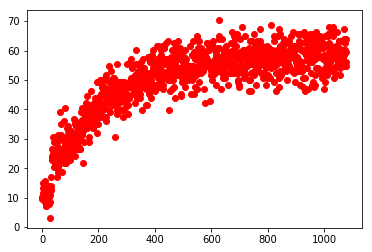

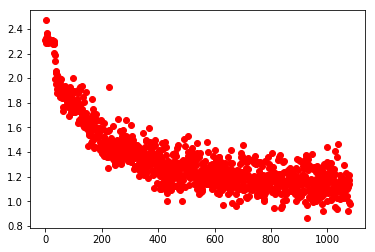

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

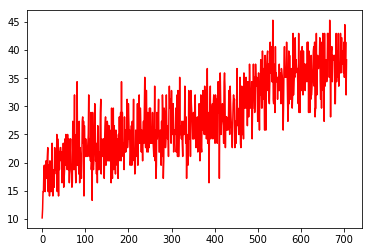

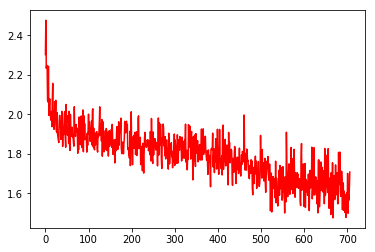

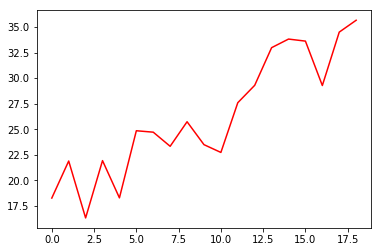

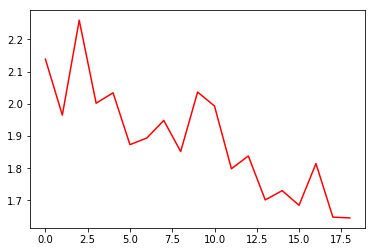

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()